In [69]:
import requests
from datetime import date
import datetime
from datetime import datetime  
from datetime import timedelta  
import dateutil.parser
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [70]:
url = 'https://data.humdata.org/hxlproxy/data/download/time_series_covid19_confirmed_global_narrow.csv?dest=data_edit&filter01=explode&explode-header-att01=date&explode-value-att01=value&filter02=rename&rename-oldtag02=%23affected%2Bdate&rename-newtag02=%23date&rename-header02=Date&filter03=rename&rename-oldtag03=%23affected%2Bvalue&rename-newtag03=%23affected%2Binfected%2Bvalue%2Bnum&rename-header03=Value&filter04=clean&clean-date-tags04=%23date&filter05=sort&sort-tags05=%23date&sort-reverse05=on&filter06=sort&sort-tags06=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv'
myfile = requests.get(url)
open(r'C:\Users\JMSch\Desktop\COVID19\Data\time_series_covid19_confirmed_global_narrow.csv', 'wb').write(myfile.content)

765306

In [83]:
data = pd.read_csv(r'C:\Users\JMSch\Desktop\COVID19\Data\time_series_covid19_confirmed_global_narrow.csv', sep = ',')

Country = 'Netherlands'
Days = 7

## Choosing the columns for later use
data = data.filter(['Country/Region', 'Date', 'Value'])
## Renaming the columns we are going to use
data.columns = ['Country', 'Date', 'Value']
## Filter which country we want to use for analysis
data = data[data.Country.eq(Country)]
## Transforming the value to int
data['Value'] = data['Value'].astype(int)
data['Date'] = data['Date'].astype('datetime64[D]')
## Summing values for 'Value' for which there are multiple records for one coutry on one day
data['Total'] = data.groupby(['Country', 'Date'])['Value'].transform('sum')
## Delete the duplicate records
data = data.drop_duplicates(subset=['Country', 'Date'])
## Sort the value from earliest to latest
data = data.sort_values(['Date'], ascending = True)
data.columns = ['Country', 'Date', 'Value', 'Confirmed']

data

,Country,Date,Value,Confirmed
12627,Netherlands,2020-01-22,0,0
12626,Netherlands,2020-01-23,0,0
12625,Netherlands,2020-01-24,0,0
12624,Netherlands,2020-01-25,0,0
12623,Netherlands,2020-01-26,0,0
...,...,...,...,...
12563,Netherlands,2020-03-26,7431,7468
12562,Netherlands,2020-03-27,8603,8647
12561,Netherlands,2020-03-28,9762,9819
12560,Netherlands,2020-03-29,10866,10930


In [84]:
## Remove the dates of which no infections were reported
data = data[data.Confirmed != 0]

## Assign a t value to each date from the first reported infection
data.insert(loc=0, column='Time', value=np.arange(len(data))+1)

## Transform the date from Excel numbers to Python dates
#data['Date'] = data['Date'].apply(lambda x: x -2)
data['Date'] = data['Date'].astype('datetime64[D]') 
data['Date'] = data['Date'].dt.strftime('%d/%m/2020')

In [85]:
data

,Time,Country,Date,Value,Confirmed
12591,1,Netherlands,27/02/2020,1,1
12590,2,Netherlands,28/02/2020,1,1
12589,3,Netherlands,29/02/2020,6,6
12588,4,Netherlands,01/03/2020,10,10
12587,5,Netherlands,02/03/2020,18,18
12586,6,Netherlands,03/03/2020,24,24
12585,7,Netherlands,04/03/2020,38,38
12584,8,Netherlands,05/03/2020,82,82
12583,9,Netherlands,06/03/2020,128,128
12582,10,Netherlands,07/03/2020,188,188


In [86]:
data['logConfirmed'] = np.log(data.Confirmed)

In [87]:
today = date.today()
## Selecting the timeframe for building the regression
LastWeek = today - timedelta(days=Days) 
LastWeek = LastWeek.strftime("%d/%m/%Y")

RowIndex = int(data.index[data['Date'] == LastWeek].tolist()[0])
## find time of index RowIndex
TimeIndex = data.at[RowIndex, 'Time']
Data_New = data[TimeIndex:]

In [88]:
X = Data_New.Time
X = sm.add_constant(X)

y = Data_New.logConfirmed

mod = sm.OLS(y, X)
res = mod.fit()
results_summary = res.summary()
print(res.summary())


OLS Regression Results                            
Dep. Variable:           logConfirmed   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     331.0
Date:                Tue, 31 Mar 2020   Prob (F-statistic):           5.37e-05
Time:                        14:59:01   Log-Likelihood:                 14.094
No. Observations:                   6   AIC:                            -24.19
Df Residuals:                       4   BIC:                            -24.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3510      0.207     25.903      0.000       4.777       5.925
T

In [89]:
## This code transforms the regression coefficients into floats to use in our prediction function
results_as_html = results_summary.tables[1].as_html()
New_DF = pd.read_html(results_as_html, header=0, index_col=0)[0]

Constant_Coefficient = New_DF.at['const','coef']
Time_Coeffificient = New_DF.at['Time','coef']

In [90]:
def linear_predictions(t):
    return np.exp(Constant_Coefficient) * np.exp(Time_Coeffificient) ** t

In [91]:
Current_Horizon = int(max(data['Time']))
Prediction_Horizon = 14 ##Change "14" to adjust the forecasting horizon
FindDate = data['Date'].iloc[-1]
MaxDate = dateutil.parser.parse(FindDate).date()

columns = ['Time', 'Date']
for i in range(Prediction_Horizon):
    New_Time = max(data['Time']) + 1
    Days_Delay = (New_Time - Current_Horizon)
    New_Date = MaxDate + timedelta(days=Days_Delay) 
    New_Date = New_Date.strftime("%d/%m/%Y")
    data = data.append({'Time': New_Time, 'Date': New_Date},ignore_index=True)


In [92]:
data['Predictions'] = data.Time.apply(linear_predictions)

In [93]:
now = datetime.now() # current date and time

Now = now.strftime("%Y%m%d_%Hh%M")

data.to_csv(f'C:\\Users\\JMSch\\Desktop\\COVID19\\Data\\Extracts\\Prediction_Output_{Country}_{Now}.csv', index = False)

No handles with labels found to put in legend.


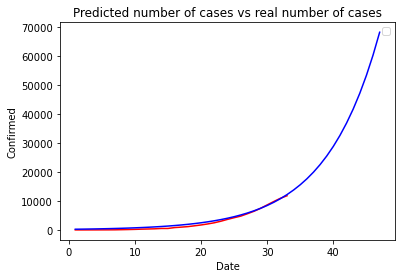

In [94]:
plt.plot(data.Time, data.Confirmed, 'red')
plt.plot(data.Time, data.Predictions, 'blue')
plt.title('Predicted number of cases vs real number of cases')
plt.xlabel('Date')
plt.ylabel('Confirmed')
plt.legend()